# Fasttext tweet classification

## Data file creation

In [1]:
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import os
import pandas as pd
import pipes
import random
import re
import tempfile
from nltk.tokenize import TweetTokenizer
from IPython.display import clear_output

In [2]:
DATADIR = "../data/"
TOPIC = "distance"
TOPIC = "mondkapje"
FILETWEETS = TOPIC+"-tweets+nunl.csv"
FILEANNOTATIONS = FILETWEETS+".human-labels.txt"
FILEFASTTEXT = "fasttext-"+TOPIC+".csv"
LABELPREFIX = "__label__"
LARGEINT = 9999999999
LABEL = "label"
TEXT = "text"
USER = "user"
IDSTR = "id_str"
IRRELEVANT = "IRRELEVANT"
NEUTRAL = "NEUTRAL"

In [3]:
tweets = pd.read_csv(DATADIR+FILETWEETS,index_col=IDSTR)
annotations = pd.read_csv(DATADIR+FILEANNOTATIONS,header=None,sep=" ")
mainAnnotator = annotations.iloc[0][0]

In [4]:
def cleanup(text):
    text = re.sub(r"\\n"," ",text)
    text = re.sub(r"https://\S+","",text)
    text = re.sub(r"\s+"," ",text)
    text = text.strip()
    return(text)

def tokenize(text):
    return(" ".join(TweetTokenizer().tokenize(text)))

def preprocess(text):
    return(tokenize(cleanup(text)).lower())

In [5]:
fasttextData = {}
for i in range(0,len(annotations)):
    annotator = annotations.iloc[i][0]
    tweetId = annotations.iloc[i][2]
    tweetLabel = annotations.iloc[i][4]
    if tweetLabel == NEUTRAL: tweetLabel = IRRELEVANT
    if annotator == mainAnnotator and tweetId in list(tweets.index):
        tweetLabel = annotations.iloc[i][4]
        tweetUser = tweets.loc[tweetId][1]
        fasttextData[tweetId] = {LABEL:LABELPREFIX+tweetLabel,\
                                 USER:tweetUser,\
                                 TEXT:preprocess(tweets.loc[tweetId][TEXT])}

In [6]:
len(fasttextData),len(tweets),len(annotations)

(2681, 8587, 2697)

In [7]:
outFile = open(FILEFASTTEXT,"w")
seenTexts = {}
for tweetId in fasttextData:
    text = cleanup(fasttextData[tweetId][TEXT])
    if not text in seenTexts:
        print(fasttextData[tweetId][LABEL],text,file=outFile)
        seenTexts[text] = True
outFile.close()

In [ ]:
annotations1 = annotations[annotations[0]==mainAnnotator]
nbrOfAnnotationMinutes = len(set([str(x)[:12] for x in annotations1[1]]))
nbrOfAnnotatedTweets = len(set([str(x)[:12] for x in annotations1[2]]))
print("tweets annotated per minute:",round(nbrOfAnnotatedTweets/nbrOfAnnotationMinutes,1),"; 1000 tweets take:",\
      round(1000/(nbrOfAnnotatedTweets/nbrOfAnnotationMinutes)),"minutes")

In [ ]:
annotations2 = annotations[annotations[0]!=mainAnnotator]
nbrOfAnnotationMinutes = len(set([str(x)[:12] for x in annotations2[1]]))
nbrOfAnnotatedTweets = len(set([str(x)[:12] for x in annotations2[2]]))
print("tweets annotated per minute:",round(nbrOfAnnotatedTweets/nbrOfAnnotationMinutes,1),"; 1000 tweets take:",\
      round(1000/(nbrOfAnnotatedTweets/nbrOfAnnotationMinutes)),"minutes")

## Fasttext run and evaluation

In [8]:
import fasttext
import random
from IPython.display import clear_output

In [9]:
PRETRAINEDDIR = "/home/erikt/projects/newsgac/fasttext-runs/"
WIKIFILENAME = "wiki.nl.vec"

In [10]:
def print_results(N, p, r):
    print("N\t" + str(N))
    print("P@{}\t{:.3f}".format(1, p))
    print("R@{}\t{:.3f}".format(1, r))

In [11]:
fasttextData = []
inFile = open(FILEFASTTEXT,"r")
for line in inFile: fasttextData.append(line.strip())
inFile.close()
len(fasttextData)

1322

In [12]:
DIM = 100
EPOCH = 100
LR = 0.05
N = 10
TRAIN = "TRAIN"+str(int(random.random()*LARGEINT))
TEST = "TEST"+str(int(random.random()*LARGEINT))

In [13]:
def ranSelect(inList,size):
    outList = []
    selectionList = list(inList)
    while len(outList) < size and len(selectionList) > 0:
        index = int(random.random()*len(selectionList))
        outList.append(selectionList[index])
        del(selectionList[index])
    return(outList)

In [14]:
def runFasttext(fasttextData,dim=DIM,epoch=EPOCH,lr=LR,n=N,squealFlag=True,maxTrain=None):
    predictionCounts = []
    predictionLabels = []
    for fold in range(0,n):
        if squealFlag:
            clear_output(wait=True)
            print("starting fold",fold)
        testStart = round(fold*len(fasttextData)/n)
        testEnd = round((fold+1)*len(fasttextData)/n)
        trainFile = open(TRAIN,"w")
        testFile = open(TEST,"w")
        trainData = []
        testData = []
        for i in range(0,len(fasttextData)):
            data = fasttextData[i]
            if i < testStart or i >= testEnd: 
                print(data,file=trainFile)
                trainData.append(data)
            else: 
                print(data,file=testFile)
                testData.append(data)
        testFile.close()
        trainFile.close()
        if not maxTrain == None and maxTrain < len(trainData):
            trainData = ranSelect(trainData,maxTrain)
            trainFile = open(TRAIN,"w")
            for i in range(0,len(trainData)):
                print(trainData[i],file=trainFile)
            trainFile.close()
        model = fasttext.train_supervised(TRAIN,dim=dim,epoch=epoch,lr=lr)
        predictionCounts.append([*model.test(TEST)])
        predictionLabels.append(model.predict(testData))
        os.unlink(TRAIN)
        os.unlink(TEST)
    if squealFlag:
        clear_output(wait=True)
        print("finished")
    return(predictionCounts,predictionLabels)

In [15]:
def makeConfusionMatrix(fasttextData,predictionLabels):
    goldLabels = pd.Series([fasttextData[i].split()[0] for i in range(0,len(fasttextData))])
    predictedLabels = pd.Series([x[0] for row in predictionLabels for x in row[0]])
    return(pd.crosstab(goldLabels,predictedLabels))

In [16]:
def evaluate(predictionCounts,predictionLabels,fasttextData,printResults=True):
    caseTotal = 0
    pTotal = 0
    rTotal = 0
    for i in range(0,len(predictionCounts)):
        caseTotal += predictionCounts[i][0]
        pTotal += predictionCounts[i][0]*predictionCounts[i][1]
        rTotal += predictionCounts[i][0]*predictionCounts[i][2]
    precision = round(pTotal/caseTotal,3)
    recall = round(rTotal/caseTotal,3)
    cf = makeConfusionMatrix(fasttextData,predictionLabels)
    for label in ['__label__REJECTS','__label__SUPPORTS','__label__IRRELEVANT']:
        if not label in cf: cf[label] = [0 for i in range(0,len(cf))]
    factor = sum(cf.loc['__label__SUPPORTS'])*sum([cf.iloc[i]['__label__REJECTS'] for i in range(0,len(cf))])/\
             (sum(cf.loc['__label__REJECTS'])*sum([cf.iloc[i]['__label__SUPPORTS'] for i in range(0,len(cf))]))
    if printResults: print("cases: {0}; precision: {1}; recall: {2}; factor: {3:0.3f}".format(caseTotal,precision,recall,factor))
    return((precision,factor))

## Grid search

In [17]:
scores = {}
for dim in [10,20,50,100,200,300]:
    for epoch in [10,20,50,100,200,300]:
        for lr in [0.05,0.1,0.2]:
            predictionCounts,predictionLabels = runFasttext(fasttextData,dim=dim,epoch=epoch,lr=lr,squealFlag=False)
            print(dim,epoch,lr,end=" ")
            key = ",".join([str(dim),str(epoch),str(lr)])
            scores[key] = evaluate(predictionCounts,predictionLabels,fasttextData)

10 10 0.05 cases: 1322; precision: 0.415; recall: 0.415; factor: inf


/home/erikt/anaconda3/envs/python37/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in long_scalars
  from ipykernel import kernelapp as app


10 10 0.1 cases: 1322; precision: 0.448; recall: 0.448; factor: 466.421
10 10 0.2 cases: 1322; precision: 0.518; recall: 0.518; factor: 5.476
10 20 0.05 cases: 1322; precision: 0.452; recall: 0.452; factor: 462.896
10 20 0.1 cases: 1322; precision: 0.523; recall: 0.523; factor: 4.805
10 20 0.2 cases: 1322; precision: 0.534; recall: 0.534; factor: 1.720
10 50 0.05 cases: 1322; precision: 0.545; recall: 0.545; factor: 2.274
10 50 0.1 cases: 1322; precision: 0.52; recall: 0.52; factor: 1.421
10 50 0.2 cases: 1322; precision: 0.525; recall: 0.525; factor: 1.397
10 100 0.05 cases: 1322; precision: 0.529; recall: 0.529; factor: 1.392
10 100 0.1 cases: 1322; precision: 0.533; recall: 0.533; factor: 1.390
10 100 0.2 cases: 1322; precision: 0.521; recall: 0.521; factor: 1.304
10 200 0.05 cases: 1322; precision: 0.533; recall: 0.533; factor: 1.389
10 200 0.1 cases: 1322; precision: 0.526; recall: 0.526; factor: 1.331
10 200 0.2 cases: 1322; precision: 0.52; recall: 0.52; factor: 1.297
10 300 0.0

In [18]:
[(scores[k],k) for k in sorted(scores.keys(),key=lambda k:scores[k][0],reverse=True)][0:10]

[((0.545, 2.2744150203166598), '10 50 0.05'),
 ((0.545, 2.291595514571949), '20 50 0.05'),
 ((0.539, 2.4978187996510077), '50 50 0.05'),
 ((0.537, 1.5887357178340784), '300 20 0.2'),
 ((0.536, 1.6201925578974758), '100 20 0.2'),
 ((0.535, 1.3625992901808348), '50 200 0.05'),
 ((0.534, 1.7202498686960117), '10 20 0.2'),
 ((0.534, 1.3605806245657521), '20 100 0.1'),
 ((0.534, 1.357619914996964), '50 100 0.1'),
 ((0.534, 1.3446990818185198), '100 200 0.05')]

In [25]:
[(scores[k],k) for k in sorted(scores.keys(),key=lambda k:scores[k][1])][0:10]

[((0.526, 1.254322747551543), '10,900,0.2'),
 ((0.523, 1.2722910835665733), '10,1500,0.2'),
 ((0.523, 1.2761117775112176), '10,700,0.2'),
 ((0.525, 1.2761117775112176), '100,900,0.2'),
 ((0.526, 1.2867551392141556), '10,500,0.2'),
 ((0.525, 1.2886843073389145), '100 300 0.2'),
 ((0.532, 1.2931252141607603), '300 300 0.2'),
 ((0.526, 1.2950639326227704), '10 300 0.2'),
 ((0.527, 1.295661945282694), '200 200 0.2'),
 ((0.52, 1.2970026510847805), '10 200 0.2')]

In [26]:
N = 5
scoresN = {} 
triplets = [(100,900,0.2),(300,300,0.2),(10,900,0.2),(200,200,0.2),(10,200,0.2)]

for triplet in triplets:
    dim,epoch,lr = triplet
    key = " ".join([str(dim),str(epoch),str(lr)])
    scoresN[key] = []
    for i in range(0,N): 
        predictionCounts,predictionLabels = runFasttext(fasttextData,dim=dim,epoch=epoch,lr=lr,squealFlag=False)
        print(dim,epoch,lr,end=" ")
        scoresN[key].append(evaluate(predictionCounts,predictionLabels,fasttextData))

100 900 0.2 cases: 1322; precision: 0.527; recall: 0.527; factor: 1.280
100 900 0.2 cases: 1322; precision: 0.526; recall: 0.526; factor: 1.294
100 900 0.2 cases: 1322; precision: 0.52; recall: 0.52; factor: 1.259
100 900 0.2 cases: 1322; precision: 0.524; recall: 0.524; factor: 1.285
100 900 0.2 cases: 1322; precision: 0.524; recall: 0.524; factor: 1.278
300 300 0.2 cases: 1322; precision: 0.526; recall: 0.526; factor: 1.291
300 300 0.2 cases: 1322; precision: 0.523; recall: 0.523; factor: 1.297
300 300 0.2 cases: 1322; precision: 0.526; recall: 0.526; factor: 1.264
300 300 0.2 cases: 1322; precision: 0.523; recall: 0.523; factor: 1.334
300 300 0.2 cases: 1322; precision: 0.528; recall: 0.528; factor: 1.323
10 900 0.2 cases: 1322; precision: 0.526; recall: 0.526; factor: 1.252
10 900 0.2 cases: 1322; precision: 0.523; recall: 0.523; factor: 1.276
10 900 0.2 cases: 1322; precision: 0.525; recall: 0.525; factor: 1.254
10 900 0.2 cases: 1322; precision: 0.523; recall: 0.523; factor: 1.27

In [27]:
scoresNaverage = {}
for key in scoresN: scoresNaverage[key] = round(np.average([x[1] for x in scoresN[key]]),3)
{key:scoresNaverage[key] for key in sorted(scoresNaverage.keys(),key=lambda k:scoresNaverage[k],reverse=True)}

{'300 300 0.2': 1.302,
 '200 200 0.2': 1.302,
 '10 200 0.2': 1.301,
 '100 900 0.2': 1.279,
 '10 900 0.2': 1.264}

In [24]:
for dim in [100]:
    for epoch in [900]:
        for lr in [0.2]:
            predictionCounts,predictionLabels = runFasttext(fasttextData,dim=dim,epoch=epoch,lr=lr,squealFlag=False)
            print(dim,epoch,lr,end=" ")
            key = ",".join([str(dim),str(epoch),str(lr)])
            scores[key] = evaluate(predictionCounts,predictionLabels,fasttextData)

100 900 0.2 cases: 1322; precision: 0.525; recall: 0.525; factor: 1.276


## Run with best parameters

In [28]:
# social distancing
BESTDIM = 20
BESTEPOCH = 300
BESTLR = 0.9
# facemasks
BESTDIM = 10
BESTEPOCH = 900
BESTLR = 0.2

In [29]:
predictionCounts,predictionLabels = runFasttext(fasttextData,dim=BESTDIM,epoch=BESTEPOCH,lr=BESTLR)

finished


In [30]:
evaluate(predictionCounts,predictionLabels,fasttextData)

cases: 1322; precision: 0.524; recall: 0.524; factor: 1.279


(0.524, 1.2785278045644488)

In [31]:
labelCountsGold = {}
for i in range(0,len(fasttextData)):
    label = fasttextData[i].split()[0]
    if label in labelCountsGold: labelCountsGold[label] += 1
    else: labelCountsGold[label] = 1
labelCountsGold

{'__label__NEUTRAL': 106,
 '__label__IRRELEVANT': 452,
 '__label__REJECTS': 549,
 '__label__SUPPORTS': 215}

In [32]:
print("baseline accuracy:",round(max(labelCountsGold.values())/sum(labelCountsGold.values()),3))

baseline accuracy: 0.415


In [33]:
labelCountsPredicted = {}
for i in range(0,len(predictionLabels)):
    for label in predictionLabels[i][0]:
        if label[0] in labelCountsPredicted: labelCountsPredicted[label[0]] += 1
        else: labelCountsPredicted[label[0]] = 1
labelCountsPredicted

{'__label__NEUTRAL': 66,
 '__label__REJECTS': 666,
 '__label__IRRELEVANT': 386,
 '__label__SUPPORTS': 204}

In [34]:
print("total absolute deviation",sum([abs(labelCountsPredicted[l]-labelCountsGold[l]) for l in labelCountsGold]))

total absolute deviation 234


In [35]:
print("relative deviation per label:",\
      {l:round(abs(labelCountsPredicted[l]-labelCountsGold[l])/labelCountsGold[l],3) for l in labelCountsGold})

relative deviation per label: {'__label__NEUTRAL': 0.377, '__label__IRRELEVANT': 0.146, '__label__REJECTS': 0.213, '__label__SUPPORTS': 0.051}


In [36]:
makeConfusionMatrix(fasttextData,predictionLabels)

col_0,__label__IRRELEVANT,__label__NEUTRAL,__label__REJECTS,__label__SUPPORTS
row_0,,,,
__label__IRRELEVANT,219,16,160,57
__label__NEUTRAL,24,9,52,21
__label__REJECTS,105,21,381,42
__label__SUPPORTS,38,20,73,84


For the mondkapje data, fasttext predicts 63% of the labels correctly without external dictionary and 66% with a Wikipedia dictionary (baseline: 46%). It overestimates the presence of negative labels and underestimates the level of positive and neutral labels. The amount of irrelevant labels is about right

In [37]:
multiplicationFactors = {}
for label in labelCountsGold:
    multiplicationFactors[label] = labelCountsGold[label]/labelCountsPredicted[label]
multiplicationFactors

{'__label__NEUTRAL': 1.606060606060606,
 '__label__IRRELEVANT': 1.1709844559585492,
 '__label__REJECTS': 0.8243243243243243,
 '__label__SUPPORTS': 1.053921568627451}

For mondkapje tweets, the multiplication factor for the positive label is unrealistically high so we will not use these factors.

In [38]:
predictedNumberOfLabels = 0
for label in labelCountsGold:
    predictedNumberOfLabels += multiplicationFactors[label]*labelCountsPredicted[label]
print(predictedNumberOfLabels,sum(labelCountsGold.values()))

1322.0 1322


## Relation data size - accuracy

In [39]:
N = 5
expResultsAll = {}
for trainingSize in [100,200,500,1000,2000,5000,10000]:
    expResultsTrainingSize = []
    for i in range(0,N):
        selection = ranSelect(fasttextData,trainingSize)
        predictionCounts,predictionLabels = runFasttext(fasttextData,dim=BESTDIM,epoch=BESTEPOCH,lr=BESTLR,squealFlag=False,maxTrain=trainingSize)
        expResultsTrainingSize.append(evaluate(predictionCounts,predictionLabels,fasttextData,printResults=False))
    average = (np.average([x[0] for x in expResultsTrainingSize]),np.average([x[1] for x in expResultsTrainingSize]))
    expResultsAll[len(selection)] = average
    print("{0:4} {1:0.3f} {2:0.3f}".format(len(selection),average[0],average[1]))
    if len(selection) >= len(fasttextData): break

 100 0.428 1.759
 200 0.451 1.341
 500 0.499 1.416
1000 0.523 1.284
1322 0.526 1.261


In [40]:
del(expResultsAll[list(expResultsAll.keys())[-1]])

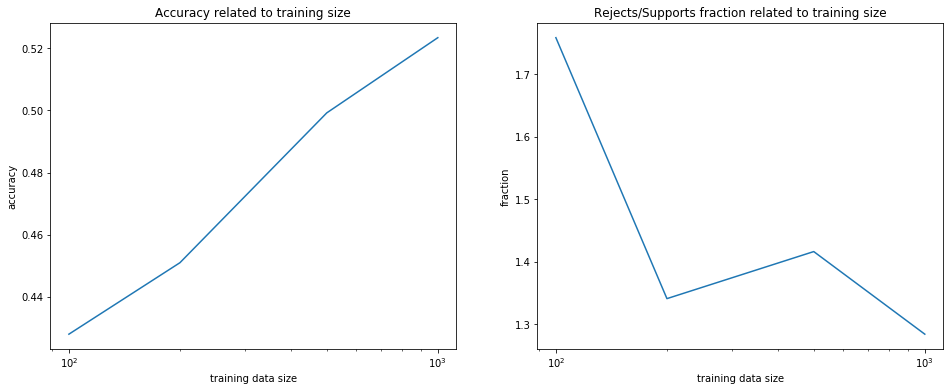

In [41]:
plt.figure(figsize=(16,6))

ax1 = plt.subplot(121)
plt.plot(list(expResultsAll.keys()),[x[0] for x in list(expResultsAll.values())])
plt.xscale("log")
plt.ylabel("accuracy")
plt.xlabel("training data size")
plt.title("Accuracy related to training size")

ax1 = plt.subplot(122)
plt.plot(list(expResultsAll.keys()),[x[1] for x in list(expResultsAll.values())])
plt.xscale("log")
plt.ylabel("fraction")
plt.xlabel("training data size")
plt.title("Rejects/Supports fraction related to training size")

plt.show()

## Classifying unlabeled tweets

In [42]:
import fasttext
import matplotlib
import os
import pandas as pd
import re
from nltk.tokenize import TweetTokenizer

In [43]:
BASEDIR = "/home/erikt/projects/puregome/data/"
DATADIRECTORY = BASEDIR+"text/"
DATADIRECTORYREDDIT = BASEDIR+"reddit/text/"
DATADIRECTORYNUNL = BASEDIR+"nunl/text/"
TWITTER = "twitter"
REDDIT = "reddit"
NUNL = "nunl"
SOURCES = [TWITTER,REDDIT,NUNL]
DATADIRECTORIES = {TWITTER:DATADIRECTORY,REDDIT:DATADIRECTORYREDDIT,NUNL:DATADIRECTORYNUNL}
TOPIC = "distance"
TOPIC = "mondkapje"
FILEFASTTEXT = "fasttext-"+TOPIC+".csv"
LABELPREFIX = "__label__"
NEGATIVE = LABELPREFIX+"NEGATIVE"
POSITIVE = LABELPREFIX+"POSITIVE"
NEUTRAL = LABELPREFIX+"NEUTRAL"
IRRELEVANT = LABELPREFIX+"IRRELEVANT"
SUPPORTS = LABELPREFIX+"SUPPORTS"
REJECTS = LABELPREFIX+"REJECTS"
TEXT = "text"
USER = "user"
TOTAL = "total"
DIM = BESTDIM
EPOCH = BESTEPOCH
LR = BESTLR

In [44]:
def cleanup(text):
    text = re.sub(r"\\n"," ",text)
    text = re.sub(r"https://\S+","",text)
    text = re.sub(r"\s+"," ",text)
    text = text.strip()
    return(text)

def tokenize(text):
    return(" ".join(TweetTokenizer().tokenize(text)))

def preprocess(text):
    return(tokenize(cleanup(text)).lower())

In [45]:
def makeGrepCommandFromQuery(query):
    grepCommand = "grep"
    for orPart in query.split("|"):
        grepCommand += ' -e "'+orPart+'"'
    return(grepCommand)

def readData(datePattern,query,dataDirectory=DATADIRECTORY):
    fileList = sorted(os.listdir(dataDirectory))
    testData = []
    for inFileName in fileList:
        if re.search(datePattern,inFileName) and os.path.exists(dataDirectory+inFileName):
            try:
                fileData = pd.read_csv(dataDirectory+inFileName).drop_duplicates()
                matchedText = [line for line in fileData[TEXT] if re.search(query,line,flags=re.IGNORECASE)]
                matchedTextPreprocessed = [preprocess(line) for line in matchedText]
                testData.extend(matchedTextPreprocessed)
            except:
                pass
    return(testData)
    
def classify(datePattern,query,model,dataDirectory=DATADIRECTORY):
    testData = readData(datePattern,query,dataDirectory)
    predictedLabels = model.predict(testData)
    predictedGroups = pd.DataFrame(predictedLabels[0]).groupby(0).groups
    labelCountsPredicted = {label:len(predictedGroups[label]) for label in predictedGroups}
    nbrOfLabels = sum([labelCountsPredicted[label] for label in labelCountsPredicted if label != IRRELEVANT])
    labelPercentages = { label:round(100*labelCountsPredicted[label]/nbrOfLabels,1) for label in labelCountsPredicted}
    labelPercentages[TOTAL] = nbrOfLabels
    return(labelPercentages)

In [46]:
QUERY = "1[.,]5[ -]*m|afstand.*hou|hou.*afstand|anderhalve[ -]*meter"
QUERY = TOPIC
MAXDAYSPERMONTH = 31

model = fasttext.train_supervised(FILEFASTTEXT,dim=BESTDIM,epoch=BESTEPOCH,lr=BESTLR)

In [47]:
results = {}
for source in SOURCES:
    dataDirectory = DATADIRECTORIES[source]
    total = 0
    results[source] = {}
    for month in "202002 202003 202004 202005 202006 202007".split():
        for day in range(1,MAXDAYSPERMONTH+1):
            date = month+str(day).zfill(2)
            try:
                labels = classify(date,QUERY,model,dataDirectory=dataDirectory)
                if not REJECTS in labels: labels[REJECTS] = 0
                if not SUPPORTS in labels: labels[SUPPORTS] = 0
                if not IRRELEVANT in labels: labels[IRRELEVANT] = 0
                if labels[REJECTS]+labels[SUPPORTS]+labels[IRRELEVANT] > 0:
                    results[source][date] = labels
                    print(source,date,labels[REJECTS],labels[SUPPORTS],labels[IRRELEVANT],labels[TOTAL])
                    total += labels[TOTAL]
            except:
                print(source,date,"error")
    print("total relevant found:",total)

twitter 20200201 73.8 11.3 73.8 168
twitter 20200202 83.7 9.5 78.9 147
twitter 20200203 68.6 14.3 61.9 105
twitter 20200204 84.8 8.3 33.8 145
twitter 20200205 59.6 31.9 40.4 94
twitter 20200206 76.7 15.1 47.9 73
twitter 20200207 64.6 20.5 29.9 127
twitter 20200208 73.8 15.6 24.6 122
twitter 20200209 73.9 15.2 32.6 46
twitter 20200210 74.7 16.0 32.0 75
twitter 20200211 79.5 2.6 46.2 39
twitter 20200212 46.6 43.1 13.8 58
twitter 20200213 77.3 11.4 34.1 44
twitter 20200214 73.1 19.2 50.0 26
twitter 20200215 73.5 17.6 17.6 34
twitter 20200216 88.2 5.9 20.6 34
twitter 20200217 71.3 11.5 29.9 87
twitter 20200218 86.6 9.0 113.4 67
twitter 20200219 86.2 10.3 51.7 29
twitter 20200220 84.2 10.5 26.3 19
twitter 20200221 81.7 6.7 109.2 120
twitter 20200222 59.0 15.7 65.1 229
twitter 20200223 67.8 16.1 50.0 118
twitter 20200224 66.8 11.6 51.7 259
twitter 20200225 69.5 13.6 25.9 999
twitter 20200226 68.3 22.6 26.9 1142
twitter 20200227 67.7 18.5 36.4 1387
twitter 20200228 73.5 12.7 40.5 1266
twitter

## Visualization over time

In [48]:
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [49]:
def movingAverage(numberList,size):
    newList = []
    for i in range(0,len(numberList)):
        numberUsed = 1
        newList.append(numberList[i])
        for j in range(1,size):
            if i-j >= 0:
                newList[i] += numberList[i-j]
                numberUsed += 1
        newList[i] /= numberUsed
    return(newList)

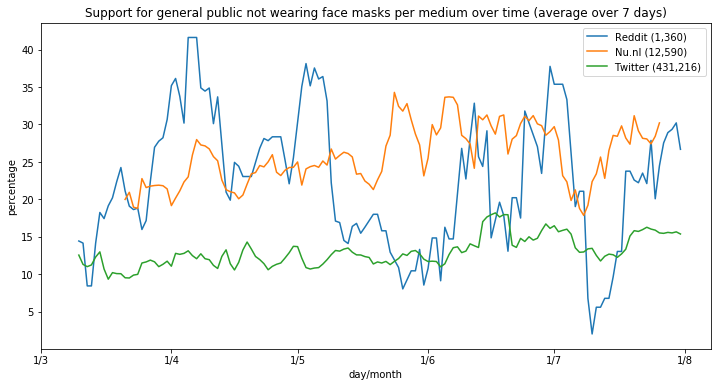

In [54]:
DATEFORMAT = "%Y%m%d"
DAYSCOMBINED = 7
STARTDATE = "20200310"
PLOTFILENAME = "social-distancing-all.png"
PLOTFILENAME = "mondkapje-all.png"
LABELS = {TWITTER:"Twitter (431,216)",NUNL:"Nu.nl (12,590)",REDDIT:"Reddit (1,360)"}

x = {}
ySupports = {}
plt.subplots(figsize=(12,6))
ax = plt.subplot(111)
for source in [REDDIT,NUNL,TWITTER]:
    x[source] = [datetime.datetime.strptime(k,DATEFORMAT) for k in results[source].keys()]
    ySupports[source] = movingAverage([results[source][k][SUPPORTS] for k in results[source].keys()],DAYSCOMBINED)
    xPart = [x[source][i] for i in range(0,len(x[source])) if x[source][i] >= datetime.datetime.strptime(STARTDATE,DATEFORMAT)] 
    ySupportsPart = [ySupports[source][i] for i in range(0,len(x[source])) if x[source][i] >= datetime.datetime.strptime(STARTDATE,DATEFORMAT)] 
    plt.plot_date(xPart,ySupportsPart,fmt="-",label=LABELS[source])
plt.legend()
plt.ylabel("percentage")
plt.xlabel("day/month")
plt.title("Support for general public not wearing face masks per medium over time (average over "+str(DAYSCOMBINED)+" days)")
plt.xticks([datetime.datetime.strptime(d,DATEFORMAT) for d in "20200301 2020401 20200501 20200601 20200701 20200801".split()])
ax.xaxis.set_major_formatter(mdates.DateFormatter("%-d/%-m"))
plt.savefig(PLOTFILENAME)
plt.show()

In [ ]:
allResults = results
results = results[TWITTER]
x = [datetime.datetime.strptime(k,DATEFORMAT) for k in results.keys()]
ySupports = movingAverage([results[k][SUPPORTS] for k in results.keys()],DAYSCOMBINED)
yRejects = movingAverage([results[k][REJECTS] for k in results.keys()],DAYSCOMBINED)
yIrrelevant = movingAverage([results[k][IRRELEVANT] for k in results.keys()],DAYSCOMBINED)

keyDates = []
for i in range(0,len(yIrrelevant)):
    if i < len(yIrrelevant)-1 and \
       (yIrrelevant[i] < 100 and yIrrelevant[i+1] >= 100 or yIrrelevant[i] >= 100 and yIrrelevant[i+1] < 100):
        keyDates.append(list(results.keys())[i])
        print(keyDates[-1])

In [ ]:
STARTDATE = "20200310" # keyDates[0]
ENDDATE = "20201231"
PLOTFILEOUT = "social-distancing.png"

results = {k:results[k] for k in sorted(results.keys())}
font = {"size":14}
matplotlib.rc("font",**font)
plt.subplots(figsize=(14,7))

ax1 = plt.subplot(121)
plt.plot_date(x,ySupports,fmt="-",label="Supports")
plt.plot_date(x,yRejects,fmt="-",label="Rejects")
plt.plot_date(x,yIrrelevant,fmt="-",label="Other")
plt.plot_date(x,[100 for i in x],fmt="-",label="100%",color="black")
for date in [STARTDATE]:
    plt.plot_date([datetime.datetime.strptime(date,DATEFORMAT)],[100],color="black")
plt.legend()
plt.ylabel("percentage")
plt.xlabel("day/month")
plt.title("stance on the RIVM policy on "+"social")

dates = [d for d in results.keys()]
xPart = [x[i] for i in range(0,len(dates)) if dates[i] >= STARTDATE and dates[i] <= ENDDATE]
ySupportsPart = [ySupports[i] for i in range(0,len(dates)) if dates[i] >= STARTDATE and dates[i] <= ENDDATE] 
yRejectsPart = [yRejects[i] for i in range(0,len(dates)) if dates[i] >= STARTDATE and dates[i] <= ENDDATE]
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%-d/%-m"))

ax2 = plt.subplot(122)
plt.plot_date(xPart,ySupportsPart,fmt="-",label="Supports")
plt.plot_date(xPart,yRejectsPart,fmt="-",label="Rejects")
plt.legend()
plt.ylabel("percentage")
plt.xlabel("day/month")
plt.title("Nu.nl on social distancing (average over "+str(DAYSCOMBINED)+" days)")
plt.xticks([datetime.datetime.strptime(d,DATEFORMAT) for d in "20200301 2020401 20200501 20200601 20200701 20200801".split()])
ax2.xaxis.set_major_formatter(mdates.DateFormatter("%-d/%-m"))

plt.savefig(PLOTFILEOUT)
plt.show()

In [ ]:
counts = {}
for text in fasttextData:
    label = text.split()[0]
    if label in counts: counts[label] += 1
    else: counts[label] = 1
for label in counts: print(round(counts[label]/len(fasttextData),3),label)

## Annotator comparison

In [ ]:
NBROFTESTDATA = 100

annotators = []
annotatorData = {}
kappaData = [{},{}]
blockedTweetIds = {}
for i in range(0,len(annotations)):
    annotator = annotations.iloc[i][0]
    tweetId = annotations.iloc[i][2]
    tweetLabel = annotations.iloc[i][4]
    if not annotator in annotatorData: 
        annotatorData[annotator] = {}
        annotators.append(annotator)
    annotatorData[annotator][tweetId] = tweetLabel
    if len(annotatorData[annotator]) <= NBROFTESTDATA: blockedTweetIds[tweetId] = True
    if len(annotators) >= 2 and not tweetId in blockedTweetIds and \
       tweetId in annotatorData[annotators[0]] and tweetId in annotatorData[annotators[1]]:
        kappaData[0][tweetId] = annotatorData[annotators[0]][tweetId]
        kappaData[1][tweetId] = annotatorData[annotators[1]][tweetId]

In [ ]:
for annotator in annotatorData:
    labelCount = {}
    for tweetId in annotatorData[annotator]:
        label = annotatorData[annotator][tweetId]
        if not label in labelCount: labelCount[label] = 0
        labelCount[label] += 1
    print(len(annotatorData[annotator]))
    for label in labelCount: print(round(labelCount[label]/len(annotatorData[annotator]),3),label)

In [ ]:
from sklearn.metrics import cohen_kappa_score

cohen_kappa_score([kappaData[0][tweetId] for tweetId in kappaData[0]],[kappaData[1][tweetId] for tweetId in kappaData[0]])

In [ ]:
MAX = 100

total = 0
identical = 0
for tweetId in annotatorData[mainAnnotator]:
    for annotator in annotators:
        if not annotator == mainAnnotator and tweetId in annotatorData[annotator]:
            total += 1
            if total <= MAX:
                if annotatorData[annotator][tweetId] == annotatorData[mainAnnotator][tweetId]: identical += 1
                else: 
                    print(tweetId,annotatorData[mainAnnotator][tweetId],annotatorData[annotator][tweetId])
                    #print(tweets.loc[tweetId][TEXT])
print(total,identical)